## Workflow to analyze pyControl data

```bash
jupyter nbconvert "D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20220929_171800_workflow_pyCon_CuedUncuedAll.ipynb" --to="python" --output-dir="D:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical" --output="nb20220929_171800_workflow_pyCon_CuedUncuedAll"
```

### Imports

In [1]:
# Import Session and Experiment class with helper functions
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables

In [2]:
import pandas as pd

trial_window = [-2000, 6000] # in ms


# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.path.split(os.getcwd())[0])

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [3]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


# Optional

1m 7s

In [4]:
photo_root_dir = 'T:\\Data\\head-fixed\\pyphotometry\\data'
pycontrol_root_dir = 'T:\\Data\\head-fixed\\pycontrol'

root_folders = [photo_root_dir, pycontrol_root_dir]
horizontal_folder_pycontrol = 'T:\\Data\\head-fixed\\test_folder\\pycontrol'
horizontal_folder_photometry = 'T:\\Data\\head-fixed\\test_folder\\photometry'

copy_files_to_horizontal_folders(
    root_folders, horizontal_folder_pycontrol, horizontal_folder_photometry)


### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [5]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
pycontrol_files_path = r'T:\Data\head-fixed\kms_pycontrol'
# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

Saved sessions loaded from: sessions.pkl


## retain only pavlovian sessions

In [6]:
exp_cohort.sessions = exp_cohort.get_sessions(task_names='reaching_go_spout_cued_uncued')
# exp_cohort.save()
len(exp_cohort.sessions )

221

### Perform extraction of behavioural information by trial

3m 7.6s

In [7]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, 
  blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
# exp_cohort.save()

reaching_go_spout_cued_uncued 41 2022-05-11 17:30:36 25 29
reaching_go_spout_cued_uncued 42 2022-05-11 17:32:14 5 0
reaching_go_spout_cued_uncued 42 2022-05-11 17:47:30 38 3
reaching_go_spout_cued_uncued 43 2022-05-11 19:24:51 34 57
reaching_go_spout_cued_uncued 44 2022-05-11 19:24:51 22 37
reaching_go_spout_cued_uncued 45 2022-05-11 19:27:52 25 55
reaching_go_spout_cued_uncued 41 2022-05-12 15:28:29 33 105
reaching_go_spout_cued_uncued 42 2022-05-12 15:33:00 44 88
reaching_go_spout_cued_uncued 43 2022-05-12 16:32:18 51 61
reaching_go_spout_cued_uncued 44 2022-05-12 16:32:18 30 40
reaching_go_spout_cued_uncued 45 2022-05-12 16:37:28 11 0
reaching_go_spout_cued_uncued 45 2022-05-12 16:54:09 5 2
reaching_go_spout_cued_uncued 41 2022-05-16 13:21:21 3 0
reaching_go_spout_cued_uncued 46 2022-05-16 13:21:21 4 0
reaching_go_spout_cued_uncued 41 2022-05-16 13:27:41 1 0
reaching_go_spout_cued_uncued 46 2022-05-16 13:27:41 1 0
reaching_go_spout_cued_uncued 41 2022-05-16 13:30:31 29 23
reaching_g

In [8]:
len(exp_cohort.sessions)

180

In [9]:
exp_cohort.sessions[1].df_events.head(50)

,timestamp,trigger,valid,success,bar_trial_time,bar_off_trial_time,spout_trial_time
trial_nb,,,,,,,
1,3952,cued,True,False,[],[],[]
2,17861,cued,True,False,[],[],[]
3,33579,cued,True,False,[],[],[]
4,48880,cued,True,False,[],[],[]
5,64024,cued,True,False,[],[],[]
6,77067,cued,True,False,[],[],[2498]
7,87495,cued,True,False,[],[],[]
8,101267,cued,True,False,[],[],[]
9,115738,cued,True,False,[],[],[]


### Define conditions and groups for extraction

#### Cued/Uncued

In [13]:
# List of uncued conditions as listed on the tasks .csv file for task reaching_go_spout_cued_uncued:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'trigger': 'cued', 'valid': True,
                    'reward spout cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict1 = {'trigger': 'cued', 'valid': True,
                    'reward bar cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict2 = {'trigger': 'cued', 'valid': True,
                    'reward free': True, 'success': True}
conditions_dict3 = {'trigger': 'cued', 'valid': True, 'success': False}
conditions_dict4 = {'trigger': 'uncued', 'valid': True,
                    'reward spout uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict5 = {'trigger': 'uncued', 'valid': True,
                    'reward bar uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict6 = {'trigger': 'uncued', 'valid': True,
                    'reward free_uncued': True}  # reward after [20, 30] s

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3,
                  conditions_dict4, conditions_dict5, conditions_dict6]
# Aliases for conditions
cond_aliases = [
    'Cued, reward at spout, hit',
    'Cued, reward at bar release, hit',
    'Cued, Pavlovian, hit',
    'Cued, miss',
    'Uncued, reward at spout, hit',
    'Uncued, reward at bar release, hit',
    'Uncued, miss']

# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)

trial_window = [-2000, 6000]


In [14]:
exp_cohort.sessions

Behaviour: Create a dataset

In [15]:
ev_dataset = exp_cohort.behav_events_to_dataset(
        groups = groups,
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
    task_names='reaching_go_spout_cued_uncued',
        trig_on_ev = None)

ev_dataset.set_trial_window(trial_window=trial_window, unit='milliseconds')
ev_dataset.set_conditions(conditions=condition_list, aliases=cond_aliases)


d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\process\data_import.py:1640: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  events_aggreg['datetime'] = pd.Series([session.datetime] * events_aggreg.shape[0], index = events_aggreg.index)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\process\data_import.py:1641: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  events_aggreg['datetime_string'] = pd.Series([session.datetime_string] * events_aggreg.shape[0], index =  events_aggreg.index)
d:\onedrive - nexus365\private_dropbox\projects\trialexp\trialexp\process\data_import.py:1672: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast 

Behaviour: Compute distribution

In [16]:
dist_as_continuous = ev_dataset.compute_distribution(
    trial_window=trial_window,
        bin_size = 100, # do not work as expected with cued-uncued
        normalize = True,
        per_session = True,
        out_as_continuous = True)
dist_as_continuous.set_conditions(conditions=condition_list, aliases=cond_aliases)
# Remove test files
dist_as_continuous.filterout_subjects([0,1])


### Optional methods

- Implementation of these optional filtering options is first understood as removing subjects, groups, conditions...
- It is a non-permanent way of discarding elements for analysis
- It is based on a "keep" column in the metadata that is True by default and set to False with the filtering function.
- At anytime, <trial_dataset>.filter_reset() can be called to re-include all the elements in the analysis (set all "keep" to True)
- Comment or uncomment lines and fill the lists according to your needs

In [17]:
# # Get a list of the groups
# dist_as_continuous.get_groups()
# # Get a list of the variables
# dist_as_continuous.get_col_names()

# # reset previous filtering of the dataset
# dist_as_continuous.filter_reset()

# # exclude some conditions by IDs
# dist_as_continuous.filterout_conditions([])

# # exclude some groups by IDs
# dist_as_continuous.filterout_groups([])

# # exclude some subjects
# dist_as_continuous.filterout_subjects([0, 1])
# #     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# # filter subjects/sessions with less than x trials (by condition)
# dist_as_continuous.filter_min(min_trials = 1)

# # To remove subjects who do not have trials
# # in all the conditions, if called after filter_min(),
# # will discard any subject who do not have the minimum number
# # of trials in all the conditions

# # dist_as_continuous.filter_if_not_in_all_cond()


Indicative preview of the behavioural metadata

In [18]:
dist_as_continuous.metadata_df.head(50)

,condition_ID,group_ID,subject_ID,session_nb,bar_trial_time,bar_off_trial_time,spout_trial_time,trial_ID,bar_dist,bar_off_dist,spout_dist,keep
0,0,0,41,11,"[382, 473, 9838, 11433, 25363, 25396, 25725, 2...","[344, 439, 556, 11376, 11455, 25381, 25625, 25...","[881, 954, 1156, 1572, 2418, 2656, 2849, 2875,...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
1,0,0,41,16,"[4564, 8645, 3309, 3517, 3678, 3803, 2578, 742...","[1528, 8229, 286, 3502, 407, 3747, 809, 7116, ...","[1686, 1881, 2101, 2464, 2761, 3345, 3997, 854...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
2,0,0,41,22,"[3590, 3682, 4321, 5616, 9016, 9185, 7611, 804...","[457, 3665, 4297, 940, 8489, 9158, 416, 7662, ...","[632, 720, 772, 1186, 2478, 3388, 3798, 4289, ...",2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
3,0,0,41,23,"[2813, 2877, 1635, 1717, 3481, 3938, 4210, 455...","[438, 2836, 344, 1683, 3457, 3706, 4160, 4327,...","[544, 577, 724, 952, 1182, 1556, 1783, 2414, 4...",3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
4,0,0,41,24,"[-1206.0, -1367.0, -1300.0, 3944.0, -1139.0, 2...","[610, 433, 435, 395, 1764, 982]","[712, 810, 1492, 1891, 530, 676, 773, 1474, 17...",4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.6666666666666667, 1.66666666...",True
5,0,0,41,25,"[3989, 4122, 27371, 27560, 27586, 28746, 29343...","[602, 4093, 27355, 27524, 27575, 28710, 29328,...","[1008, 1088, 1160, 1267, 1697, 1956, 2176, 256...",5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
6,0,0,41,29,[463],"[422, 511]","[875, 1049, 1470, 2417]",6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
7,0,0,41,36,"[-1900.0, -1207.0, 3948.0, 9055.0, -1279.0, -1...","[-1222, 1692, 1041, 690, -1890, 1141, -1225, 1...","[1819, 1944, 2113, 2609, 3296, 3482, 1267, 130...",7,"[0.9090909090909091, 0.6060606060606061, 0.606...","[0.6060606060606061, 0.30303030303030304, 0.30...","[0.0, 0.6060606060606061, 0.30303030303030304,...",True
8,0,0,41,37,"[-1999.0, 2535.0, 2571.0, -1562.0, -1499.0, 19...","[795, 2550, 478, -1546, 409, 1931, 1957, 375, ...","[1058, 1198, 1395, 1615, 2063, 633, 709, 806, ...",8,"[0.38461538461538464, 0.38461538461538464, 0.1...","[0.28846153846153844, 0.28846153846153844, 0.0...","[0.0, 0.38461538461538464, 0.19230769230769232...",True
9,0,0,41,39,"[-1481, 2172, 2208, 2351, 2990, 3753, 3949, 39...","[-1531, 1798, 2187, 2313, 2973, 3731, 3931, 39...","[-1481, 1883, 579, 659, 1543, 1829, 1925, 2256]",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, ...",True


## Behaviour: Plot distribution

#TODO what is T = 0?
How to plot differently? Or not necessary?

True    911
Name: keep, dtype: int64

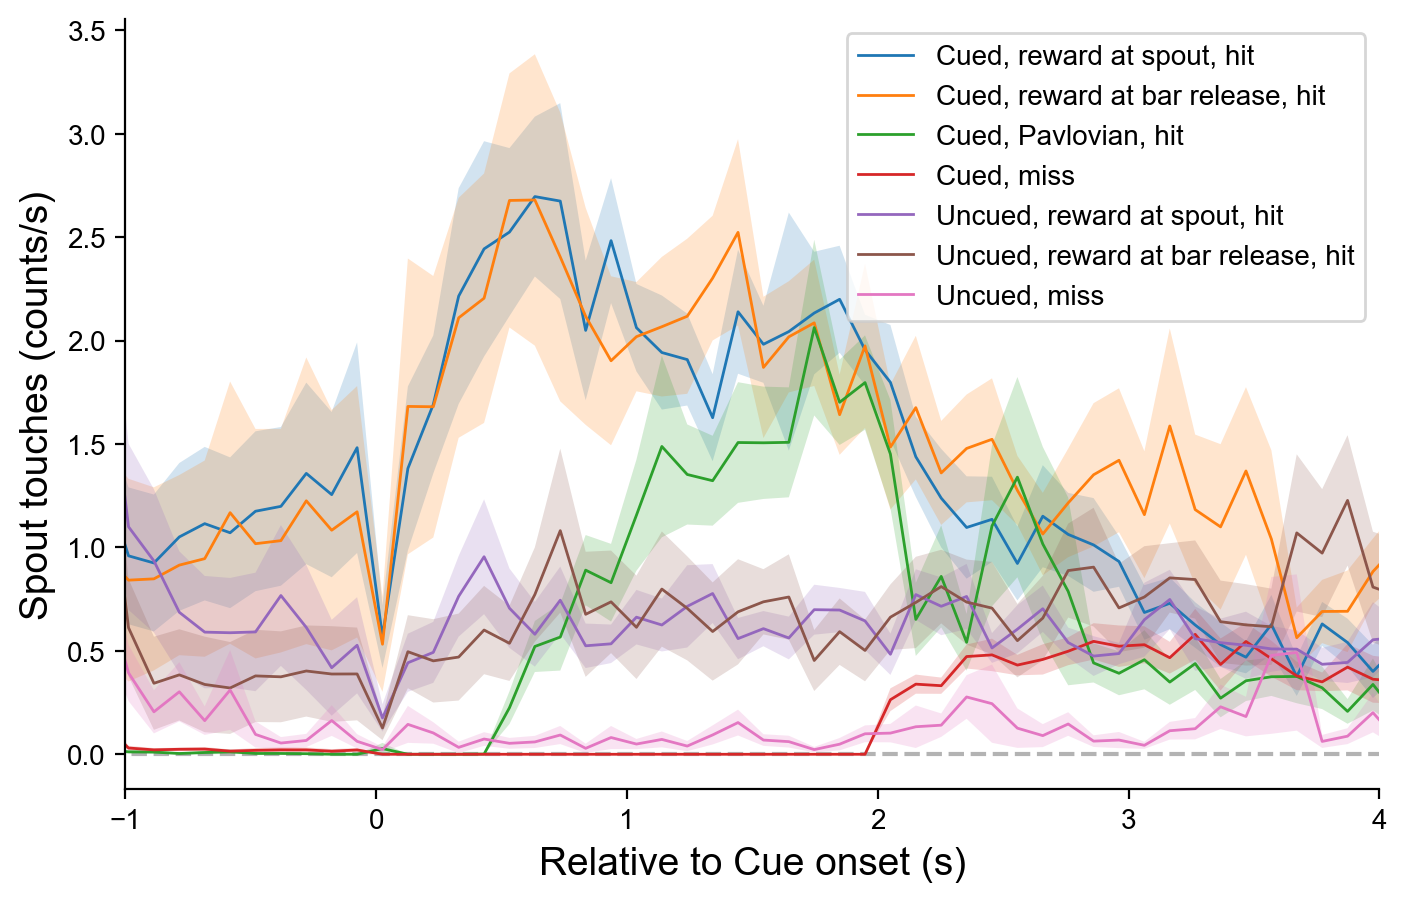

In [19]:
import trialexp.utils.pycontrol_utilities as pycutl

dist_as_continuous.set_trial_window([a/1000 for a in trial_window], 's')

figs, axs, df1 = dist_as_continuous.lineplot(
    vars = [ 'spout_dist'],
    time_lim = [-1,4],
    time_unit='s',
    error = True,
    ylim = None,#[[-0.1,1.6]], #[[-0.1, 0.7]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = pycutl.cmap10(),
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5*1.618, 5),
    dpi = 200,
    verbose = False)


axs[0, 0].set_xlabel('Relative to Cue onset (s)', fontsize=14) #TODO not sure
axs[0, 0].set_ylabel('Spout touches (counts/s)', fontsize=14) #TODO not sure
# Return a count of overall number of trials
dist_as_continuous.metadata_df['keep'].value_counts()


# Success rate plots 

## Sessions

Mmmmm, what about Cued and Uncued blocks!!!

I can look into 'Cued' column, but this cannot be generalised!!!

I need clear definition of what is devided by what in which trials1!!

sucess is alywas counted.

But within what?

{'Cued': True}

or 

{'Cued' : False}

Confusingly this is different from the `conditions` used above which is the list of all the conditions you're interested.

Here you can specify it as logical OR of multiple conditions, but if `conditions` are not thorough, this won't work. 

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


(     group_ID  subject_ID  session_nb  success_n  trial_n  success_rate
 0           0          41          10         72      142      0.507042
 1           0          41          11        138      190      0.726316
 2           0          41          12          4       13      0.307692
 3           0          41          13          1        4      0.250000
 4           0          41          14         64      132      0.484848
 ..        ...         ...         ...        ...      ...           ...
 169         0          53          25        107      156      0.685897
 170         0          53          26         32       49      0.653061
 171         0          53          27         23       27      0.851852
 172         0          53          29          2        2      1.000000
 173         0          53          31         64      132      0.484848
 
 [174 rows x 6 columns],
 [                  41        42        43        44        45        46  \
  session_nb         

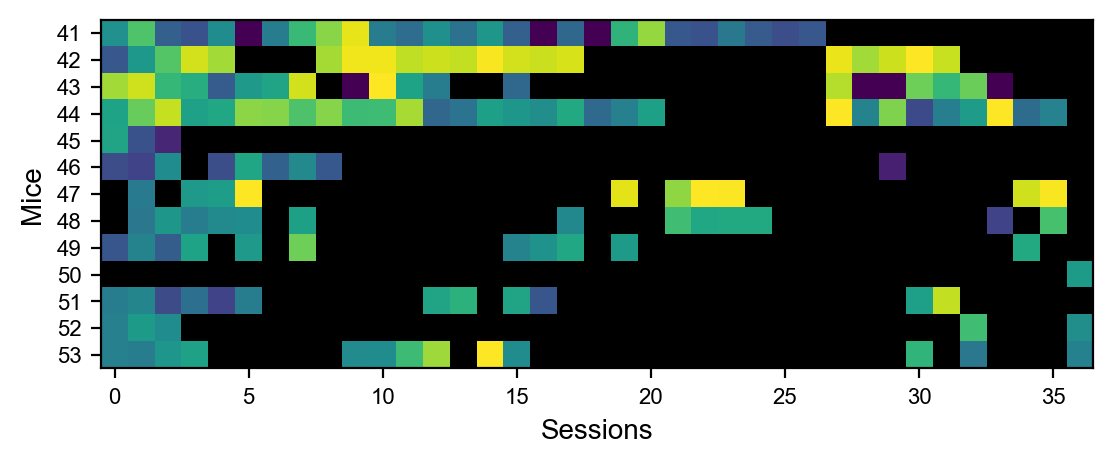

In [27]:
ev_dataset.analyse_successrate(bywhat='sessions')



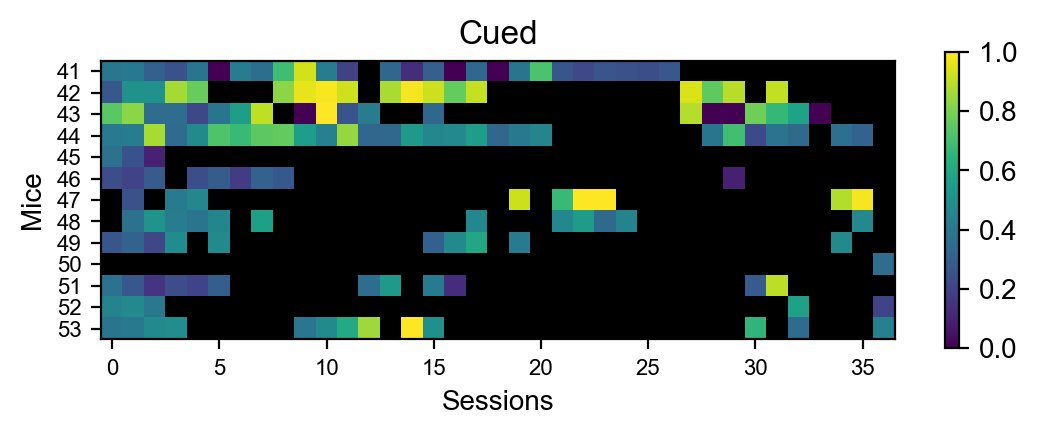

In [45]:
gr_df, out_list, ax, im1  = ev_dataset.analyse_successrate(bywhat='sessions',
    conditions={'cued':True})

ax.set_title('Cued')

plt.colorbar(im1, shrink=0.4)


        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


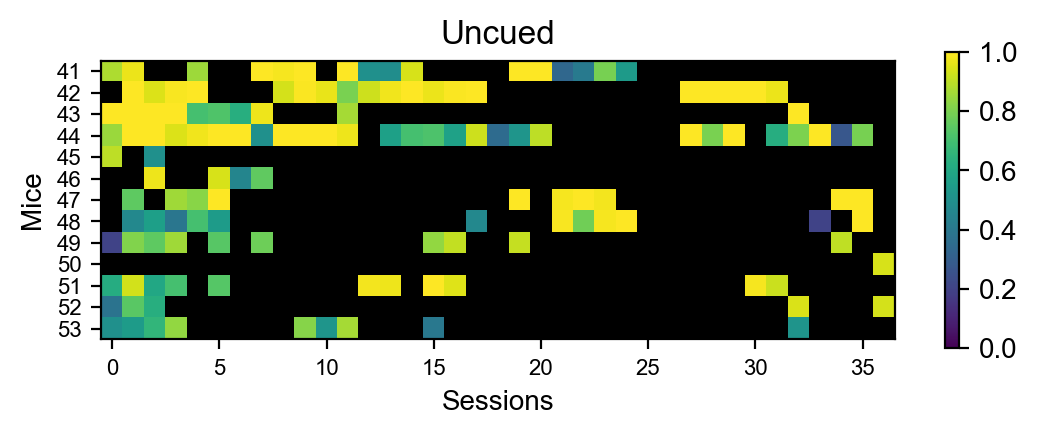

In [44]:

gr_df, out_list, ax, im1  = ev_dataset.analyse_successrate(bywhat='sessions',
    conditions={'cued':False})

ax.set_title('Uncued')

plt.colorbar(im1, shrink=0.4)

In [ ]:
gr_df, out_list, ax, im1 = ev_dataset.analyse_successrate(bywhat='days',
                                                          conditions={'cued': False})

ax.set_title('Uncued')

plt.colorbar(im1, shrink=0.4)


In [57]:
gr_df, out_list, ax, im1 = ev_dataset.analyse_successrate(bywhat='days',
                                                          conditions={'cued': True})

ax.set_title('Cued')

plt.colorbar(im1, shrink=0.4)


AttributeError: Can only use .dt accessor with datetimelike values

In [58]:
mdf = ev_dataset.metadata_df

In [61]:
np.count_nonzero((mdf['group_ID'] == 0) & (
    mdf['subject_ID'] == 47) & (mdf['success'])  & (mdf['cued'] == True))


874

### Set DeepLabCut bodyparts to compute paws centroids

In [158]:
# Name of the labelled body parts from both upper limbs
# The bodyparts from which we draw here are user-defined
# when creating a new DeepLabCut project (config.yaml)

L_paw_parts  = ['MCP II', 'MCP III', 'MCP IV', 'MCP V', 'IP II', 'IP III', \
    'IP IV', 'IP V', 'tip II', 'tip III', 'tip IV', 'tip V'] 

R_paw_parts = ['r MCP II', 'r MCP III', 'r MCP IV', 'r MCP V', 'r IP II', \
    'r IP III', 'r IP IV', 'r IP V', 'r tip II', 'r tip III', 'r tip IV', 'r tip V']

names_of_ave_regions = ['Left_paw','Right_paw']

### Extract DeepLabCut trials and create a Continuous_Dataset

In [ ]:
cont_dataset = exp_cohort.get_deeplabcut_groups(
        groups = None,
        conditions_list = condition_list,
        cond_aliases = cond_aliases,
        when='all', 
        task_names = ['reaching_go_nogo'],
        bodyparts_to_ave = [L_paw_parts, R_paw_parts],
        names_of_ave_regions = ['Left_paw','Right_paw'], 
        bodyparts_to_store = ['spout', 'jaw', 'ear', 'tongue', 'tip III',  'IP III', 'MCP III'],
        normalize_between = ['Left_paw', 'spout'],
        bins_nb = 100,
        three_dims = False, 
        p_thresh = 0.9,
        camera_fps = 100, # not yet functional
        camera_keyword = 'Side', 
        trig_on_ev = None, 
        verbose = True)


### Save DLC Dataset

In [338]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs'

cont_dataset.save(folder_path, 'DLC_dataset_gonogo')

PicklingError: Can't pickle <class 'trial_dataset_classes.Continuous_Dataset'>: it's not the same object as trial_dataset_classes.Continuous_Dataset

### Reload a pre-existing dataset

In [110]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\DLC_dataset_opto_continuous_full.pkl'
cont_dataset = load_dataset(dataset_full_path)

In [111]:
cont_dataset.metadata_df

,subject_ID,datetime,task_name,condition_ID,trial_nb,session_nb,group_ID,keep,trial_ID
0,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,8,34,0,False,0
1,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,11,34,0,False,1
2,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,12,34,0,False,2
3,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,19,34,0,False,3
4,280,2021-11-18 15:11:25,reaching_go_nogo_opto_continuous,0,22,34,0,False,4
...,...,...,...,...,...,...,...,...,...
9114,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,60,37,2,False,9114
9115,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,64,37,2,False,9115
9116,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,142,37,2,False,9116
9117,293,2022-01-21 15:31:54,reaching_go_nogo_opto_continuous,7,144,37,2,False,9117


### Optional methods

In [374]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([0, 1,289,299,305,306])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 10)

# To remove subjects who do not have
# trials in all the conditions
# cont_dataset.filter_if_not_in_all_cond()

# method to build (not finished)
# cont_dataset.set_groups()


In [375]:
%load_ext autoreload
%autoreload 2

from trial_dataset_classes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


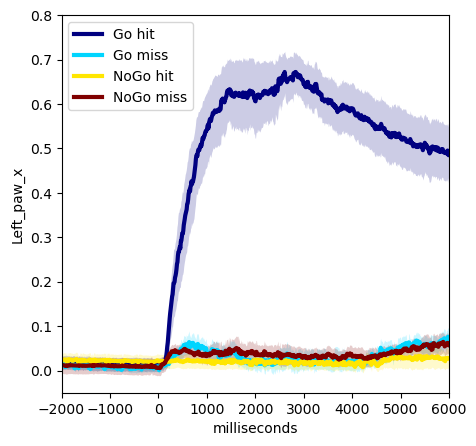

True     2800
False     628
Name: keep, dtype: int64

In [378]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')
cont_dataset.set_conditions(condition_list, cond_aliases)
cont_dataset.lineplot(
    vars = ['Left_paw_x'],
    time_lim = [-2000, 6000],
    time_unit = 'milliseconds',
    error = True,
    ylim = [[-0.05, 0.8]], #[[-0.1, 1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5,5),
    dpi = 100,
    verbose = False)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()


In [ ]:
%load_ext autoreload
%autoreload 2
cont_dataset.set_groups(groups)

In [276]:
cont_dataset.metadata_df.keep[cont_dataset.metadata_df.subject_ID == 307].value_counts()

True     308
False    233
Name: keep, dtype: int64

In [177]:
for row in cont_dataset.metadata_df.itertuples():
    print(row.group_ID)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [171]:
row

Pandas(Index=0, subject_ID=0, datetime=Timestamp('2021-11-18 14:37:48'), task_name='reaching_go_nogo_opto_continuous', condition_ID=0, trial_nb=4, session_nb=160, group_ID=0, keep=False, trial_ID=0)

In [172]:
row.subject_ID

0

In [62]:
cont_dataset.data

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


NameError: name 'cont_dataset' is not defined